# Metient-calibrate

### This tutorial is intended for those who want to run Metient in calibrate mode, and have Metient infer (1) the proportions of each clone in each anatomical site, and (2) the labeled clone tree. 

### To run this notebook, you'll need metient installed:

```bash
mamba create -n "met" python=3.8.8 ipython
mamba activate met
pip install metient
```

### Import libraries and setup paths

In [1]:
import os
from metient import metient as met

### Setup paths
# Path to where our input clone trees and tsvs are located
input_dir = os.path.join(os.getcwd(), "inputs")
# Path to save outputs
output_dir = os.path.join(os.getcwd(), "1_outputs")

CUDA GPU: False


### An example of the expected tsv file format for melanoma patient A
**The required columns are:**
`anatomical_site_index, anatomical_site_label, cluster_index, character_index, character_label, ref, var, var_read_prob, site_category` (see `../README.md` for description of each column)

In [2]:
import pandas as pd
df = pd.read_csv(os.path.join(input_dir, "A_SNVs.tsv"), sep="\t")
df

,anatomical_site_index,anatomical_site_label,cluster_index,character_index,character_label,ref,var,var_read_prob,site_category
0,0,"Primary, forehead",0,0,ADCY5,213,118,0.380,primary
1,1,Parotid metastasis,0,0,ADCY5,382,27,0.105,metastasis
2,2,"Locoregional skin metastasis 1, forehead",0,0,ADCY5,319,67,0.210,metastasis
3,3,"Locoregional skin metastasis 2, angle jaw",0,0,ADCY5,188,66,0.310,metastasis
4,0,"Primary, forehead",0,1,ZNF148,117,58,0.380,primary
...,...,...,...,...,...,...,...,...,...
535,3,"Locoregional skin metastasis 2, angle jaw",0,133,TECTA,120,55,0.310,metastasis
536,0,"Primary, forehead",0,134,ANKRD17,160,116,0.380,primary
537,1,Parotid metastasis,0,134,ANKRD17,302,33,0.105,metastasis
538,2,"Locoregional skin metastasis 1, forehead",0,134,ANKRD17,278,68,0.210,metastasis


## Step 1: Load filepaths to clone trees and tsv files for each patient in Sanborn et al. Melanoma dataset

In [3]:
patients = ["A", "B", "C", "D", "E", "F", "G"]

clone_tree_fns = [os.path.join(input_dir, f"{patient}_tree.txt") for patient in patients]
ref_var_fns = [os.path.join(input_dir, f"{patient}_SNVs.tsv") for patient in patients]

## Step 2: Run Metient-calibrate

Saving results to /lila/data/morrisq/divyak/projects/metient/tutorial/1_outputs/calibrate
Overwriting existing directory at /lila/data/morrisq/divyak/projects/metient/tutorial/1_outputs/calibrate

*** Calibrating for patient: A ***
ordered_sites ['Primary, forehead', 'Parotid metastasis', 'Locoregional skin metastasis 1, forehead', 'Locoregional skin metastasis 2, angle jaw']


  0%|          | 2/650 [00:00<00:39, 16.34it/s]

node indices not well estimated []


  6%|▋         | 41/650 [00:00<00:16, 36.27it/s]/lila/data/morrisq/divyak/projects/metient/metient/lib/v_optimizer.py:406: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  known_labelings.append(torch.eye(v_solver.num_sites)[optimal_site].T)
 98%|█████████▊| 636/650 [00:05<00:00, 129.54it/s]

pareto_metrics {(4, 3, 1)}
# final solutions: 1

*** Calibrating for patient: B ***
ordered_sites ['Primary, mid-left back', 'Lymph node metastasis, left axilla', 'Locoregional skin metastasis 1, left back', 'Locoregional skin metastasis 2, left axilla']


  1%|          | 6/650 [00:00<00:10, 59.12it/s]

node indices not well estimated []
No potential polytomies to solve, not resolving polytomies.


 98%|█████████▊| 638/650 [00:04<00:00, 186.17it/s]

pareto_metrics {(6, 3, 1)}
# final solutions: 7

*** Calibrating for patient: C ***
ordered_sites ['Primary, right lower calf', 'Locoregional skin metastasis 1, right calf', 'Locoregional skin metastasis 2, right mid-calf']


  2%|▏         | 12/650 [00:00<00:05, 115.46it/s]

node indices not well estimated []
No potential polytomies to solve, not resolving polytomies.


 98%|█████████▊| 636/650 [00:03<00:00, 216.89it/s]

pareto_metrics {(4, 2, 1)}
# final solutions: 4

*** Calibrating for patient: D ***
ordered_sites ['Primary, right ankle', 'Lymph node metastasis, right groin', 'Locoregional skin metastasis 1, right ankle', 'Locoregional skin metastasis 2, right leg']


  2%|▏         | 11/650 [00:00<00:05, 107.25it/s]

node indices not well estimated []


 99%|█████████▉| 646/650 [00:04<00:00, 164.10it/s]

pareto_metrics {(4, 3, 1), (3, 3, 2)}
# final solutions: 2

*** Calibrating for patient: E ***
ordered_sites ['Primary, left heel', 'Locoregional skin metastasis 1, left heel', 'Locoregional skin metastasis 2, left heel', 'Lymph node metastasis, left groin', 'Locoregional skin metastasis 3, left heel']


  2%|▏         | 12/650 [00:00<00:05, 115.45it/s]

node indices not well estimated []


100%|██████████| 650/650 [00:23<00:00, 186.17it/s]

pareto_metrics {(8, 4, 1)}
# final solutions: 6

*** Calibrating for patient: F ***
ordered_sites ['Primary, left ear', 'Lymph node metastasis, left cervical node', 'Locoregional skin metastasis, left ear', 'Distant skin metastasis, back']


  2%|▏         | 10/650 [00:00<00:06, 95.24it/s]

node indices not well estimated []


100%|██████████| 650/650 [00:22<00:00, 164.10it/s]

pareto_metrics {(13, 3, 1)}
# final solutions: 3


100%|██████████| 650/650 [00:16<00:00, 107.08it/s]


*** Calibrating for patient: G ***
ordered_sites ['Primary, right forearm', 'Lung metastasis', 'Locoregional skin metastasis, axilla']


  2%|▏         | 13/650 [00:00<00:05, 126.58it/s]

node indices not well estimated []


 98%|█████████▊| 638/650 [00:03<00:00, 173.90it/s]

pareto_metrics {(3, 2, 1)}
# final solutions: 4
Calibrating to 1 patients
Early stopping after 51 epochs.
Optimized thetas: tensor([0.33, 0.33, 0.33], grad_fn=<DivBackward0>)
A_Primary, forehead
10 unique trees were not found (1 was found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

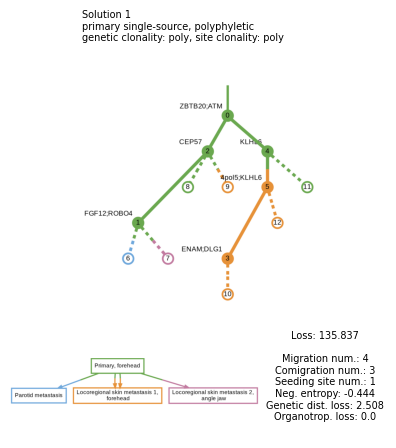

B_Primary, mid-left back
10 unique trees were not found (7 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

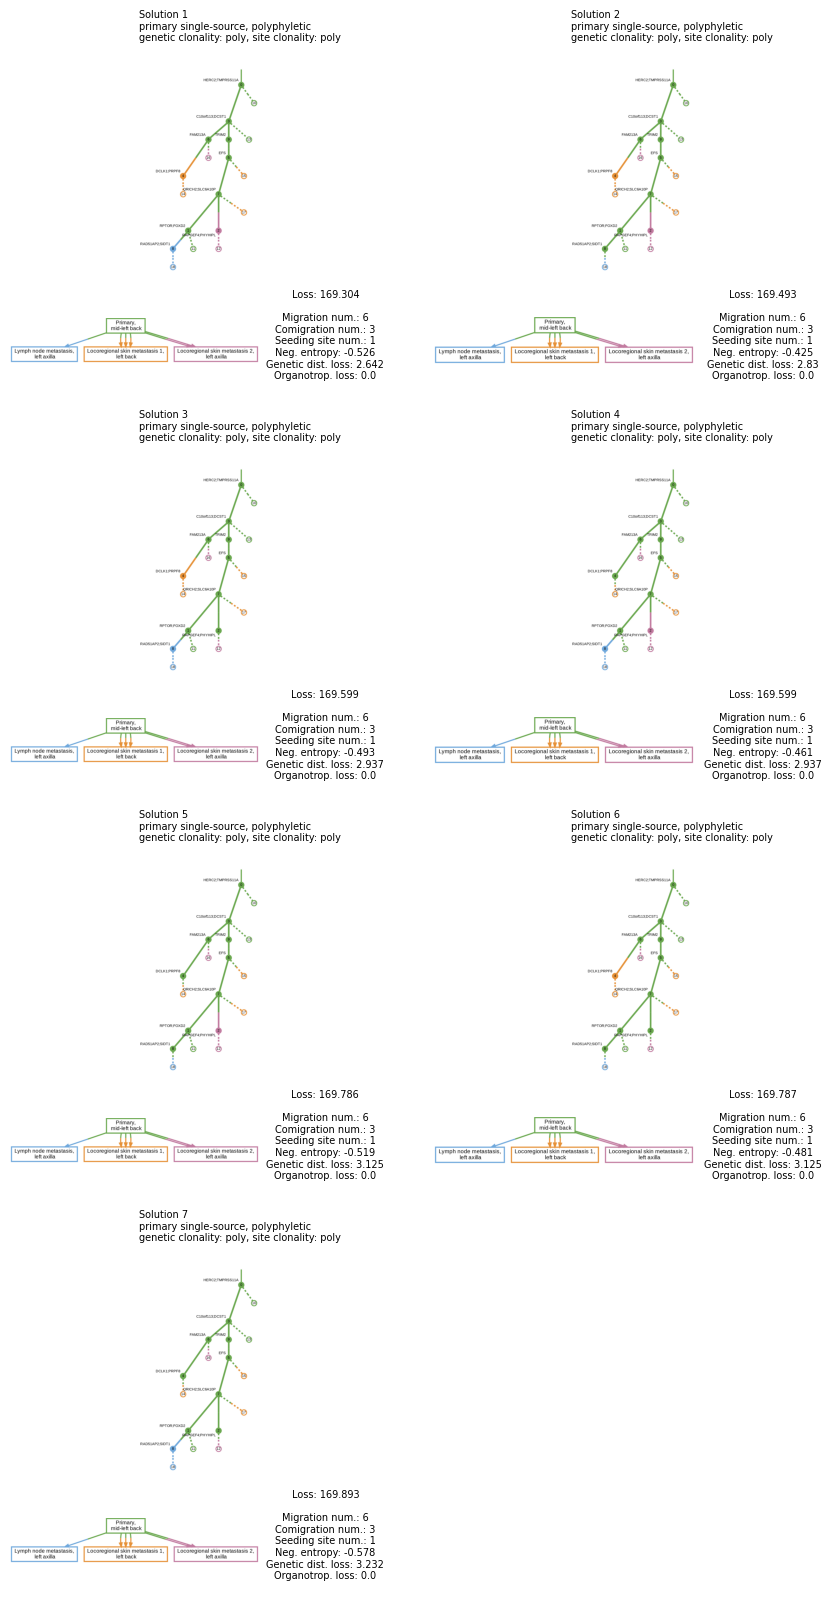

C_Primary, right lower calf
10 unique trees were not found (4 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

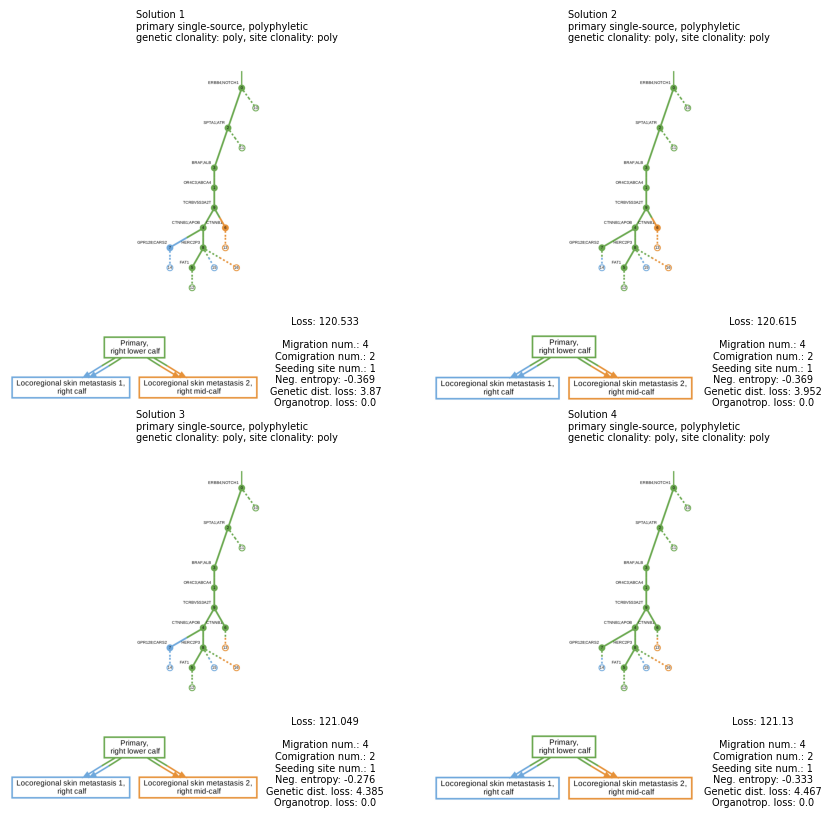

100%|██████████| 650/650 [00:19<00:00, 173.90it/s]

D_Primary, right ankle
10 unique trees were not found (2 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

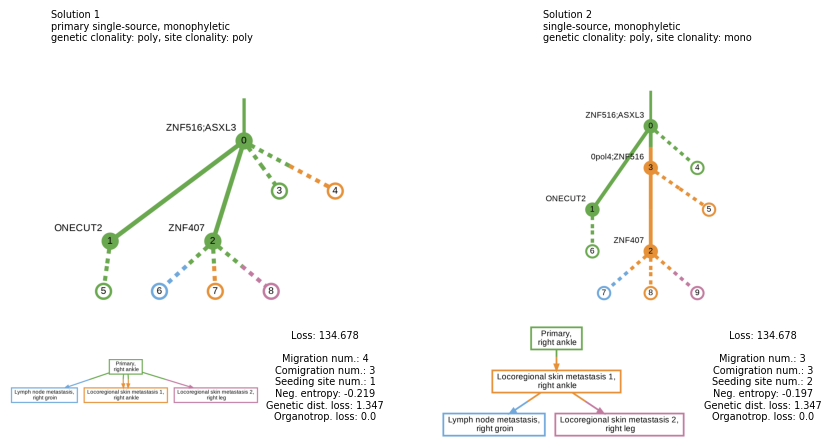

E_Primary, left heel
10 unique trees were not found (6 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

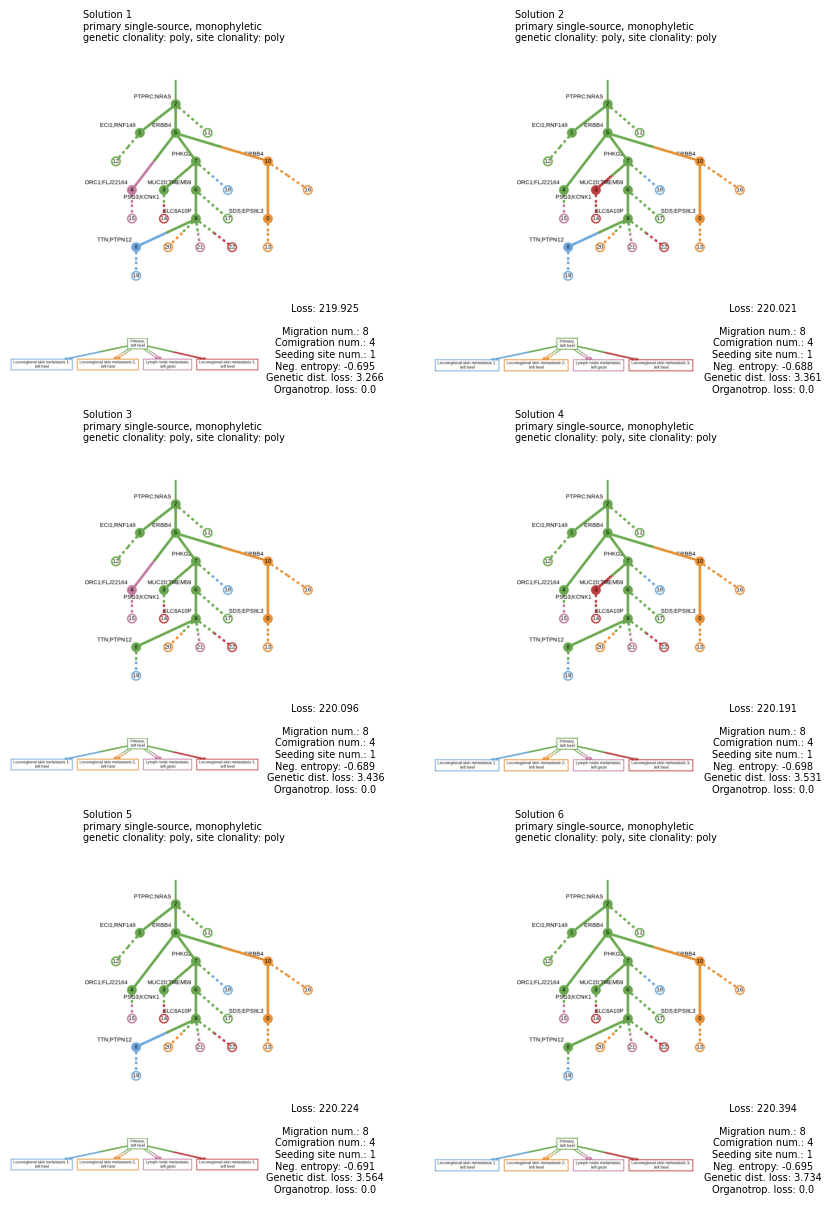

F_Primary, left ear
10 unique trees were not found (3 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

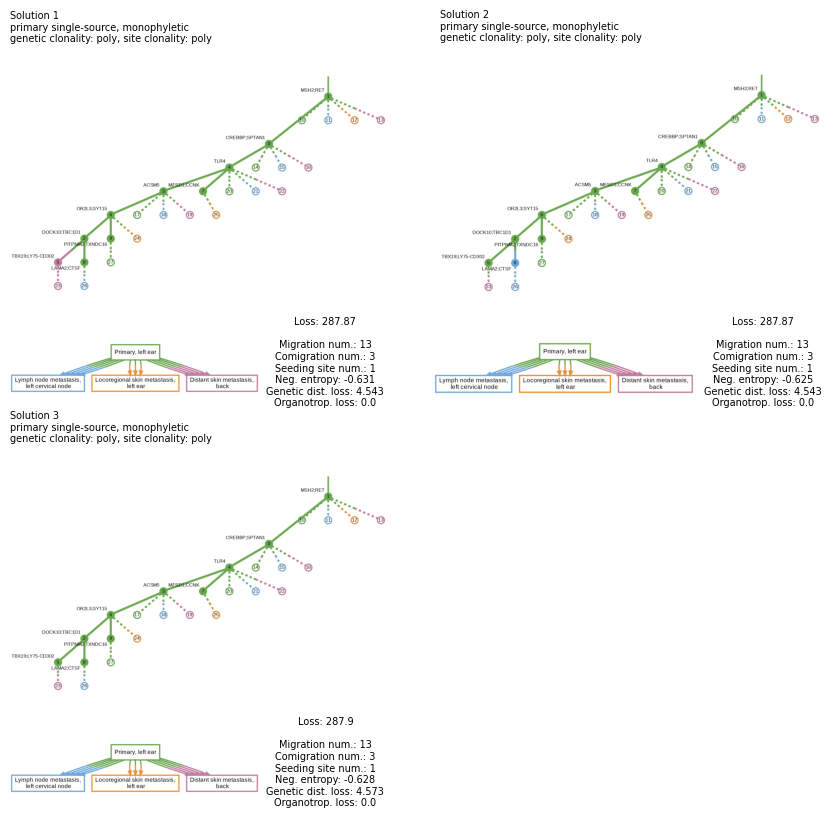

G_Primary, right forearm
10 unique trees were not found (4 were found). Retry with a higher sample size if you want to get more trees.


<Figure size 640x480 with 0 Axes>

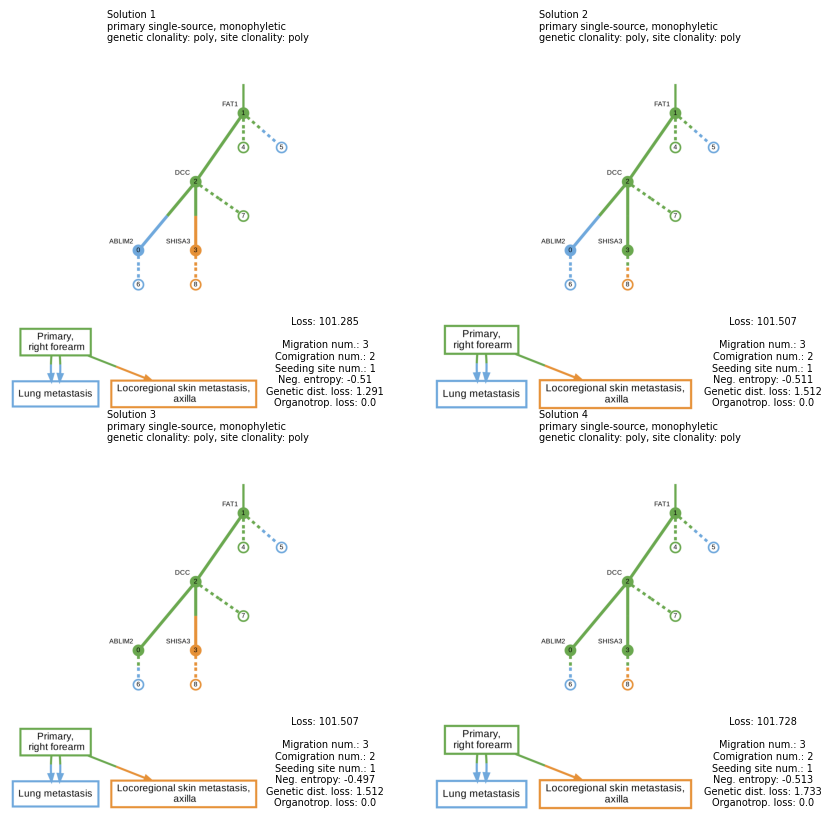

[0.3333333432674408, 0.3333333432674408, 0.3333333432674408]

In [4]:
print_config = met.PrintConfig(visualize=True, verbose=False, k_best_trees=10)
met.calibrate(clone_tree_fns, ref_var_fns, print_config, output_dir, patients, solve_polytomies=True)


## Step 3: Use the pickle file outputs for downstream analysis

### In addition to the visualizations that Metient provides, we also save pkl.gz files for each Metient run that contain all the results of the run.

In [5]:
import gzip
import pickle

with gzip.open(os.path.join(output_dir,"calibrate", "A_Primary, forehead.pkl.gz") ,"rb") as f:
    pckl = pickle.load(f)
print(pckl.keys())

BEST_TREE_IDX = 0
# V is the best ancestral labeling
V = pckl['clone_tree_labeling_matrices'][BEST_TREE_IDX]
# A is the adjacency matrix that is the input clone tree + inferred leaf nodes + polytomy resolution
A = pckl['full_adjacency_matrices'][BEST_TREE_IDX]

# G represents the migration graph
G = met.migration_graph(V, A)
print("\nmigration graph:\n", G)

node_info = pckl['node_info'][BEST_TREE_IDX]

# Show other information about this patient's inferred migration history
print("\nseeding pattern:", met.seeding_pattern(V, A))
print("seeding clusters:", met.seeding_clusters(V, A,node_info))
print("phyleticity:", met.phyleticity(V, A, node_info))
print("site clonality:", met.site_clonality(V, A))
print("genetic clonality:", met.genetic_clonality(V, A,node_info))

dict_keys(['clone_tree_labeling_matrices', 'losses', 'node_info', 'full_adjacency_matrices', 'ordered_anatomical_sites', 'loss_dict', 'primary_site', 'soft_v', 'gen_dist_matrices', 'observed_clone_proportion_matrix'])

migration graph:
 tensor([[0., 1., 2., 1.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

seeding pattern: primary single-source
seeding clusters: [1, 2, 4]
phyleticity: polyphyletic
site clonality: polyclonal
genetic clonality: polyclonal
